# Test of range data lags for the observed oscillations
    
Following tests are scripted for comprehensive characterization
- convergence to reference orbit with zero lags
- impact of a uniform lag in the range data
- impact of light-time lags, i.e., range rate and light time
- impact of light-time lags times a scale factor


In [1]:
from astropy import units as u
sampling_interval = 1*u.hour
tracking_period = 30*u.day

In [2]:
from astropy import constants as const
from astropy import visualization
from astropy.coordinates import solar_system_ephemeris
    
from poliastro.util import norm
from poliastro.twobody.sampling import EpochsArray
    
import numpy as np
import sys
sys.path.append('../')
    
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
    
from sim.stations import dss25, dss34
from sim.tracking import Tracking
from sim.util import orbit_from_horizons, make_epochs, find_rates
from sim.util import describe_orbit, describe_trajectory, plot_residual, plot_swings
from sim.fitorbit import OrbitFitter
    
def plots(epochs, residual, title, ylab):
    plot_residual(epochs, residual, title, 'Residual ' + ylab)
    try:
        e, s = plot_swings(epochs, residual, None, 'Residual swings ' + ylab)
        #print(s)
    except ValueError:
        # no swings identified
        pass
    
def fitr(ref_orbit, ref_stations, epochs, sim_meas, title, _trace=False):
    fitter = OrbitFitter(ref_orbit, ref_stations, trace=_trace)
    fitter.fit_range_data(epochs, sim_meas)
    print(fitter.report())
    print('Time elapsed (hh:mm:ss.ms) {}'.format(fitter.runtime))
    describe_orbit(fitter.orbit)
    plots(epochs, fitter.result.residual, title, 'range (m)')
    rates = find_rates(epochs, fitter.result.residual)
    plots(epochs[1:], rates, None, 'range rate (m/s)')
    return fitter, rates
    
def reusefitr(fitsolution, epochs, sim_meas, title):
    residual = fitsolution.range_residual(epochs, sim_meas)
    plots(epochs, residual, title, 'range (m)')
    rates = find_rates(epochs, residual)
    plots(epochs[11:], rates[10:], None, 'range rate (m/s)')
    return rates

In [3]:
solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value
    
near_goldstone_orbit = orbit_from_horizons("NEAR", goldstone_end)
describe_orbit(near_goldstone_orbit)


::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437.250829758486 km
Semimajor axix: -8494.322039490264 km
Periapse radius: 6908.917068596319 km , altitude: 530.7804685963192 km


In [4]:
canberra_start = Tracking.NEAR_CANBERRA_START.value
canberra_end = canberra_start + tracking_period
epochs = make_epochs(canberra_start, canberra_end, sampling_interval)
print("Start and end:", epochs[0], epochs[-1], "[", epochs.size, "]")
    
near_extended_ephem = near_goldstone_orbit.to_ephem(EpochsArray(epochs))
describe_trajectory(near_extended_ephem, dss34)

Start and end: 1998-01-23 09:53:55.600 1998-02-22 08:53:55.600 [ 720 ]

::TRAJECTORY::
Start and end ranges: 99245.7532096098 km 17847093.095720734 km
Start and end radial speeds: 7.3216176182785535 km / s 6.742051287016325 km / s
Closest: 73145.82143191747 km speed 7.5891622264313146 km / s  at  1998-01-23 09:53:55.600
Deflection: 0.457927625040083 deg


In [5]:
rdata_ref = []
rlags = []
rlags_full = []
rdata_constrlags = []
rdata_ltlags_full = []
rdata_ltlags = []
rdata_scaledlags = []
    
scalefactor = 0.1
first_rlag = None
    
for e in epochs:
    rv = near_extended_ephem.rv(e)
    ref_r, ref_rr, ref_rs = dss34.range_and_rates(rv, e)
    print(e.strftime("%H:%M:%S"),
         ref_r.to_value(u.km),
         ref_rr.to_value(u.m/u.s),
         ref_rs.to_value(u.m/u.s),
         (ref_rr+ref_rs).to_value(u.m/u.s),
         )
    
    rlag_full = ref_rr*ref_r/const.c
    rlag = (ref_rr+ref_rs)*ref_r/const.c
    
    if first_rlag is None:
        first_rlag = rlag
    
    rlags.append(rlag)
    rlags_full.append(rlag_full)
    
    rdata_ref.append([ref_r])
    rdata_constrlags.append([ref_r - first_rlag])
    rdata_ltlags_full.append([ref_r - rlag_full])
    rdata_ltlags.append([ref_r - rlag])
    rdata_scaledlags.append([ref_r - scalefactor*rlag])

09:53:55 73145.82143191747 7321.617618278554 68.79038110949617 7390.40799938805
10:53:55 99245.7532096098 7187.7369454526515 102.08657772440507 7289.823523177057
11:53:55 124953.15770282669 7100.470021274935 120.15213999260801 7220.622161267543
12:53:55 150407.26865298714 7045.180149880965 125.83416256857925 7171.014312449544
13:53:55 175706.3273609694 7013.212834377098 120.61516993443941 7133.828004311538
14:53:55 200923.61747138412 6998.968415835037 105.8921418109968 7104.860557646034
15:53:55 226115.081514972 6998.227213421146 83.32665523403492 7081.553868655181
16:53:55 251322.7147374973 7007.379229306495 54.90520121159005 7062.284430518085
17:53:55 276576.09410904173 7023.105801442162 22.879163338189827 7045.984964780352
18:53:55 301893.2139723953 7042.287322157354 -10.353411101246321 7031.933911056107
19:53:55 327281.2187505763 7062.02518157836 -42.39282624158386 7019.6323553367765
20:53:55 352737.32525912847 7079.717672930693 -70.98897839406094 7008.728694536632
21:53:55 378250.

09:53:55 3653951.7892964673 6761.824944536381 104.20660071130223 6866.031545247683
10:53:55 3678272.7248505345 6751.073585169903 114.85069023773737 6865.92427540764
11:53:55 3702568.9918970726 6748.198204665694 117.6226339397878 6865.820838605481
12:53:55 3726869.456001371 6753.391057353309 112.33001832008198 6865.721075673392
13:53:55 3751202.677460625 6766.291155776451 99.33350394514049 6865.624659721591
14:53:55 3775594.951733906 6786.00839308632 79.52273106932381 6865.531124155644
15:53:55 3800068.5032700878 6811.184175699495 54.25572730593949 6865.439903005436
16:53:55 3824639.957620258 6840.084515565956 25.265862997360994 6865.350378563317
17:53:55 3849319.1978679257 6870.719212187569 -5.457281609777388 6865.261930577792
18:53:55 3874108.684923427 6900.9788693993305 -35.80488785381226 6865.1739815455185
19:53:55 3899003.2889880626 6928.780196277255 -63.69416241754788 6865.086033859707
20:53:55 3923990.643803915 6952.209443762739 -87.2117473917294 6864.99769637101
21:53:55 3949051

16:53:55 6196129.569822868 6842.776326849414 16.803688488182278 6859.580015337597
17:53:55 6220818.917029092 6873.5438608497425 -13.997784562790768 6859.546076286952
18:53:55 6245617.930524669 6903.3510014371905 -43.83887500267586 6859.512126434515
19:53:55 6270519.427486556 6930.151106350079 -70.67312296430879 6859.47798338577
20:53:55 6295509.188723918 6952.104255185333 -92.66075048569255 6859.4435046996405
21:53:55 6320566.935886105 6967.703542451622 -108.29494853689435 6859.408593914727
22:53:55 6345667.724256617 6975.8783309677365 -116.50512798203722 6859.373202985699
23:53:55 6370783.65487171 6976.067395209574 -116.73006333594397 6859.33733187363
00:53:55 6395885.787989471 6968.257004142995 -108.95597806836334 6859.301026074632
01:53:55 6420946.126399769 6952.98143521564 -93.71706254558826 6859.264372670052
02:53:55 6445939.532678559 6931.285997563634 -72.05850241621089 6859.227495147423
03:53:55 6470845.449436906 6904.65519330286 -45.464646388492774 6859.190546914368
04:53:55 64

16:53:55 9751106.183109788 6851.747419011344 4.427938626523893 6856.175357637868
17:53:55 9775827.849663848 6882.38560236525 -26.22402856159697 6856.161573803653
18:53:55 9800657.196914509 6911.225723274094 -55.07800465424985 6856.1477186198435
19:53:55 9825584.133219443 6936.289741885392 -80.15601878578492 6856.133723099607
20:53:55 9850591.874050766 6955.858832265271 -99.73929727064535 6856.119534994626
21:53:55 9875658.093980376 6968.591244308073 -112.48612339374596 6856.105120914328
22:53:55 9900756.458397983 6973.614185165865 -117.52371805268508 6856.09046711318
23:53:55 9925858.429469565 6970.583441104012 -114.50786185984424 6856.075579244168
00:53:55 9950935.222310018 6959.706704476711 -103.64622311992255 6856.060481356788
01:53:55 9975959.7770295 6941.729077150211 -85.68386283727389 6856.045214312937
02:53:55 10000908.611826109 6917.881814247452 -61.85198059353298 6856.029833653919
03:53:55 10025763.430278469 6889.797872827409 -33.78346599283959 6856.01440683457
04:53:55 100505

23:53:55 12295216.549323056 6967.305467085534 -112.35725466690087 6854.9482124186325
00:53:55 12320277.932162205 6954.459868787196 -99.521548643261 6854.938320143935
01:53:55 12345280.459706454 6934.796044232471 -79.86772814114602 6854.9283160913255
02:53:55 12370201.883040208 6909.660928979845 -54.742690427009514 6854.918238552836
03:53:55 12395025.508214217 6880.775954449978 -25.867821226452403 6854.9081332235255
04:53:55 12419741.338818917 6850.11916562459 4.778885151361766 6854.898050775952
05:53:55 12444346.760028085 6819.789845226303 35.098198640660925 6854.888043866964
06:53:55 12468846.717507739 6791.864875620569 63.01328802806754 6854.878163648637
07:53:55 12493253.379044907 6768.25662394738 86.61183204516941 6854.86845599255
08:53:55 12517585.301907348 6750.582035070505 104.2769226957624 6854.858957766267
09:53:55 12541866.1626653 6740.05186675042 114.79782683426603 6854.849693584686
10:53:55 12566123.136155244 6737.3876485771125 117.45302488996953 6854.8406734670825
11:53:55

22:53:55 15823599.59242316 6970.296737447233 -116.40198427645178 6853.89475317078
23:53:55 15848680.124867529 6962.033976046553 -108.14513510600229 6853.888840940551
00:53:55 15873717.325084658 6946.361702732336 -92.47885829808223 6853.8828444342535
01:53:55 15898686.308687733 6924.353725239401 -70.4769419689254 6853.876783270475
02:53:55 15923566.864768052 6897.5176702123 -43.646987865089464 6853.87068234721
03:53:55 15948344.839636618 6867.691684094965 -13.827113497561982 6853.864570597404
04:53:55 15973013.10562293 6836.918569119238 16.93991028098879 6853.858479400227
05:53:55 15997572.049038466 6807.305954460613 46.546486186483634 6853.852440647096
06:53:55 16022029.543664854 6780.882043922229 72.964440614082 6853.846484536311
07:53:55 16046400.411874413 6759.456779795632 94.38385745947487 6853.840637255107
08:53:55 16070705.409961874 6744.497898643647 109.33702013587903 6853.834918779527
09:53:55 16094969.807023859 6737.0303516166 116.7989894416437 6853.829341058243
10:53:55 16119

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8
    # data points      = 720
    # variables        = 6
    chi-square         = 0.00501429
    reduced chi-square = 7.0228e-06
    Akaike info crit   = -8537.79448
    Bayesian info crit = -8510.31897
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
    nu:    at initial value
    raan:  at initial value
    argp:  at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.83942476 (init = -1.839425)
    raan:  1.54005926 (init = 1.540059)
    argp:  2.53325839 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:00:32.800184

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 690

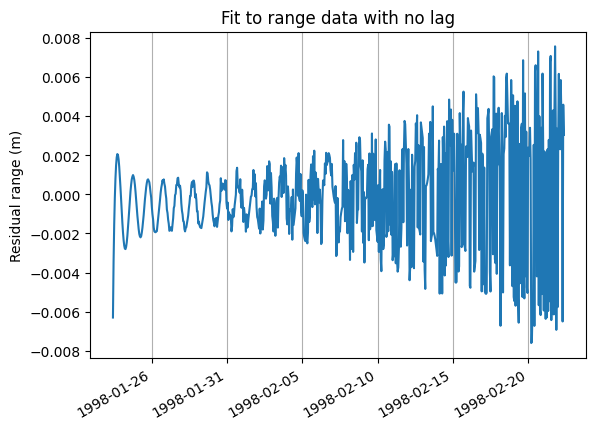

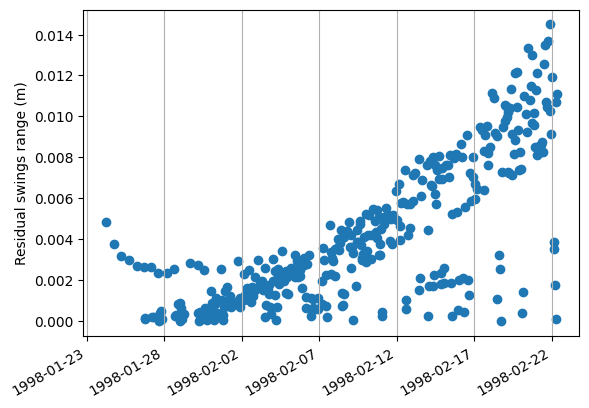

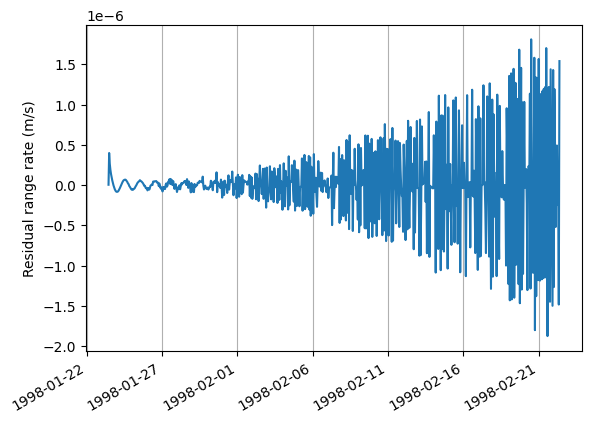

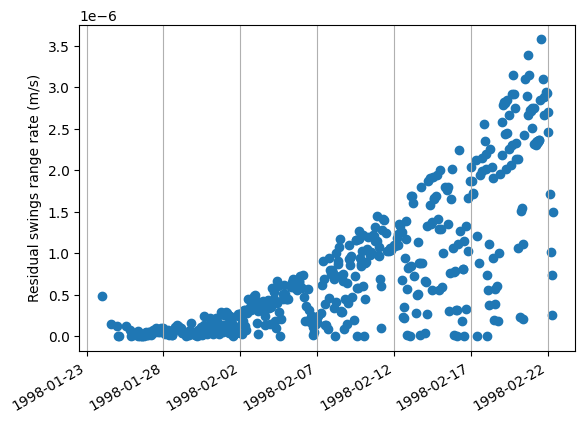

In [6]:
_,_ = fitr(near_goldstone_orbit, [dss34], epochs, rdata_ref, "Fit to range data with no lag")

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 720
    # variables        = 6
    chi-square         = 84054.2572
    reduced chi-square = 117.723049
    Akaike info crit   = 3439.17593
    Bayesian info crit = 3466.65144
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
    nu:    at initial value
    raan:  at initial value
    argp:  at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.83944122 (init = -1.839425)
    raan:  1.54005831 (init = 1.540059)
    argp:  2.53325787 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:01:18.764964

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 6908

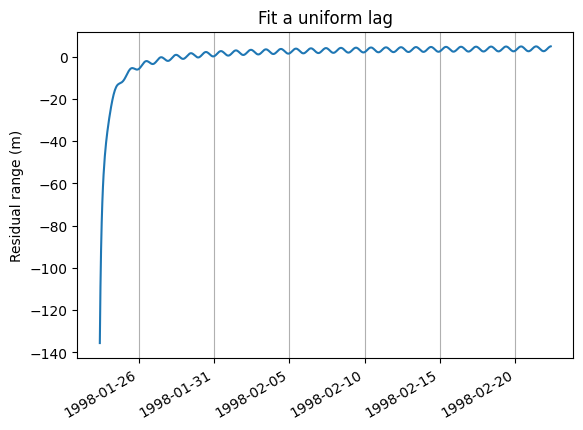

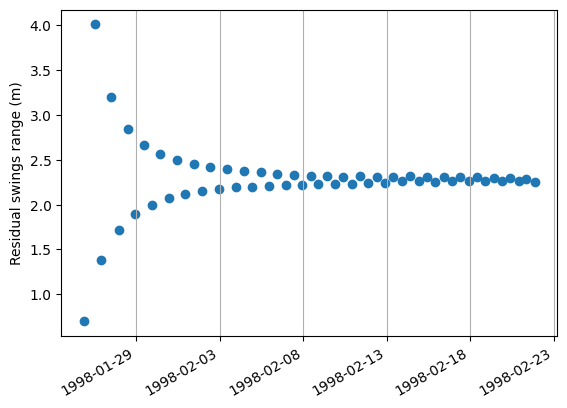

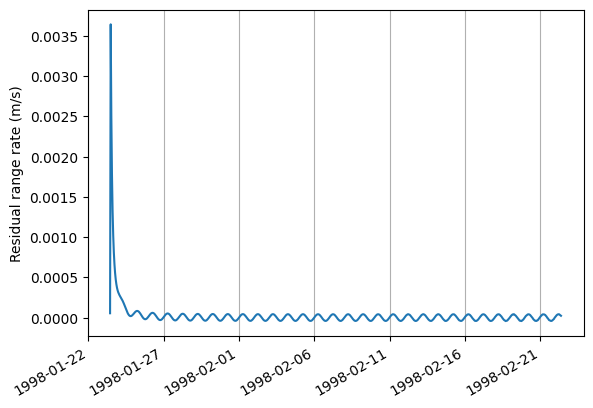

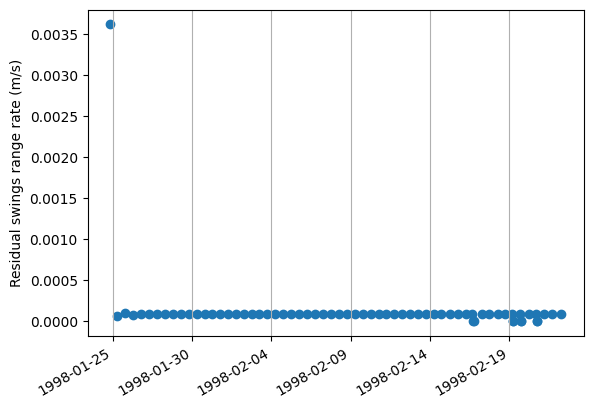

In [7]:
constfitr, const_rates = fitr(near_goldstone_orbit, [dss34], epochs, rdata_constrlags, "Fit a uniform lag")

[2.292132005095482, 2.261662855744362, 2.2842325270175934, 2.252083271741867]
[1.763821476035663e-06, 8.204020559787753e-05, 8.168630301952362e-05, 8.301912910408441e-05]


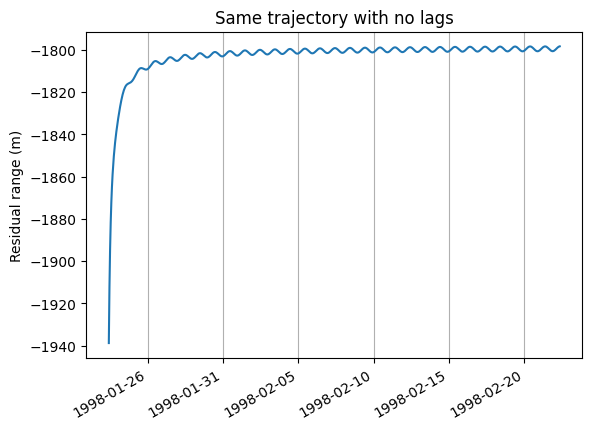

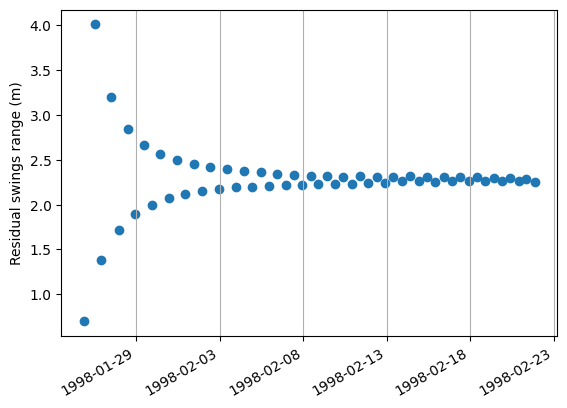

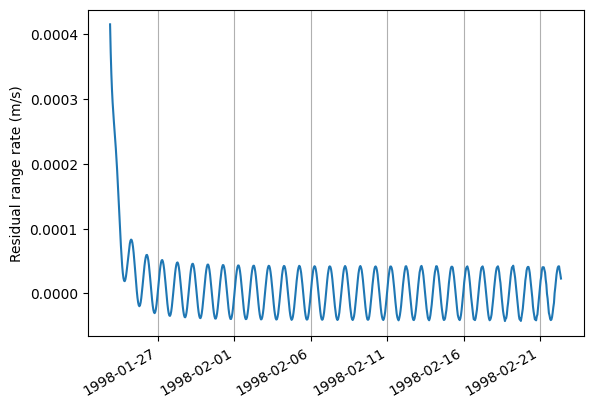

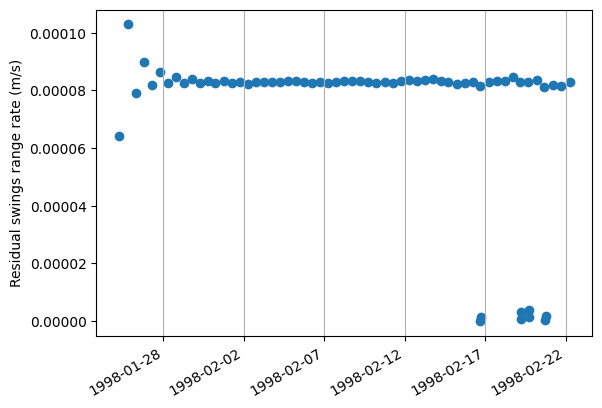

In [8]:
_ = reusefitr(constfitr, epochs, rdata_ref, "Same trajectory with no lags")

[0.0026924390759733713, 0.0026922533288598754, 0.0026935328625971033, 0.0026902359806829645]


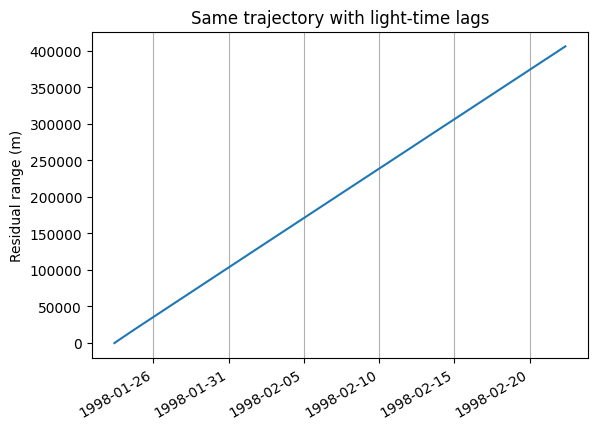

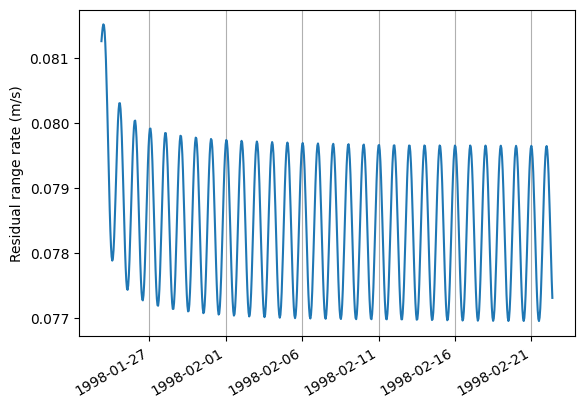

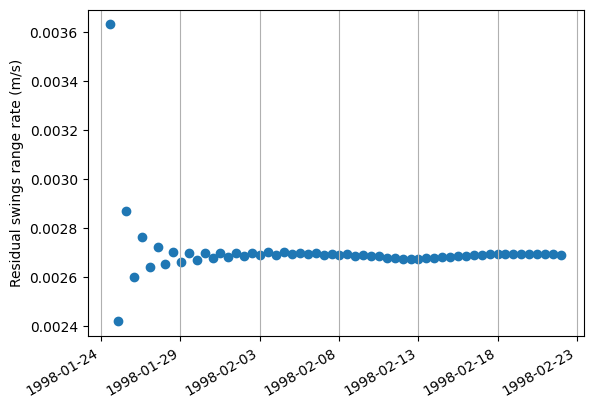

In [9]:
_ = reusefitr(constfitr, epochs, rdata_ltlags, "Same trajectory with light-time lags")

[0.0026924390759733713, 0.0026922533288598754, 0.0026935328625971033, 0.0026902359806829645]


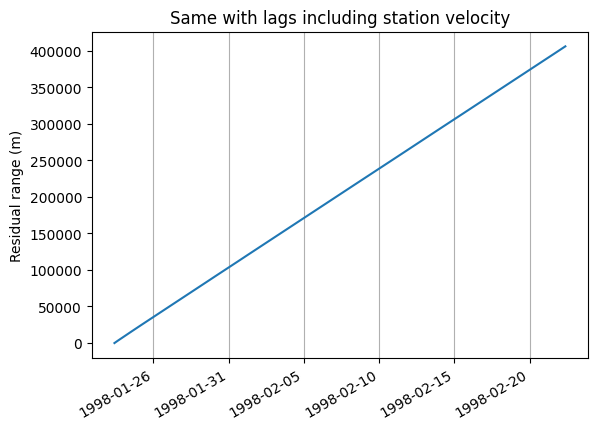

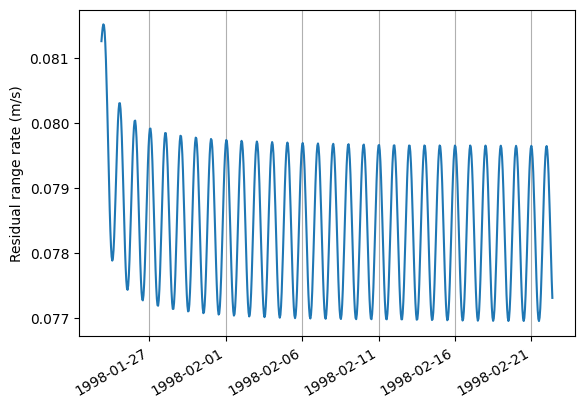

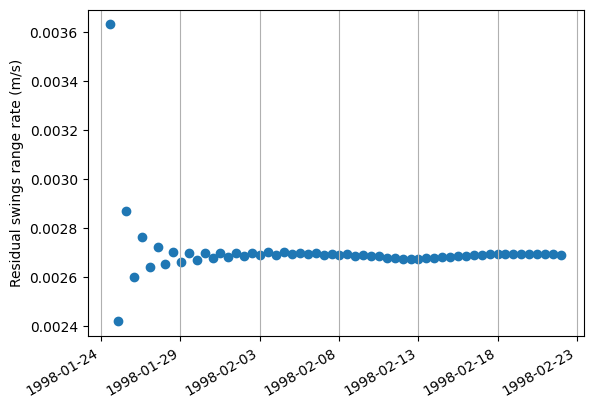

In [10]:
_ = reusefitr(constfitr, epochs, rdata_ltlags, "Same with lags including station velocity")

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 720
    # variables        = 6
    chi-square         = 1.0186e+13
    reduced chi-square = 1.4267e+10
    Akaike info crit   = 16840.4321
    Bayesian info crit = 16867.9076
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.84128317 (init = -1.839425)
    raan:  1.74782623 (init = 1.540059)
    argp:  2.59688371 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:01:47.516770

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 6908917.068596319 m , altitude: 530780.4685963197 m
[9023.730121552944, 22560.5464652180

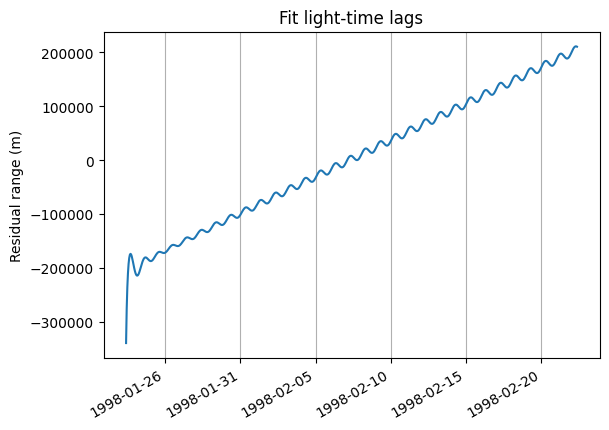

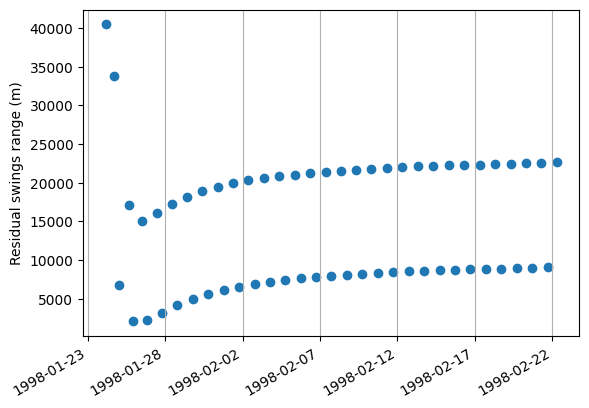

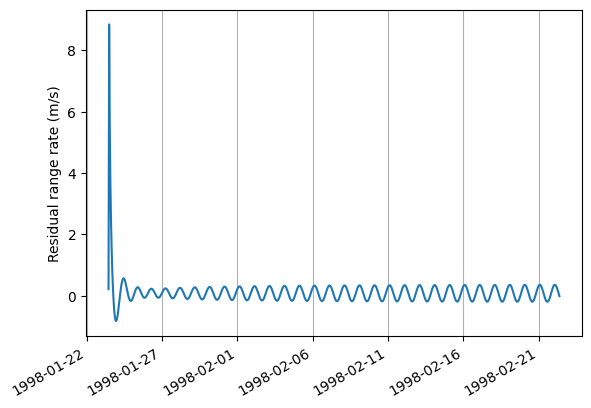

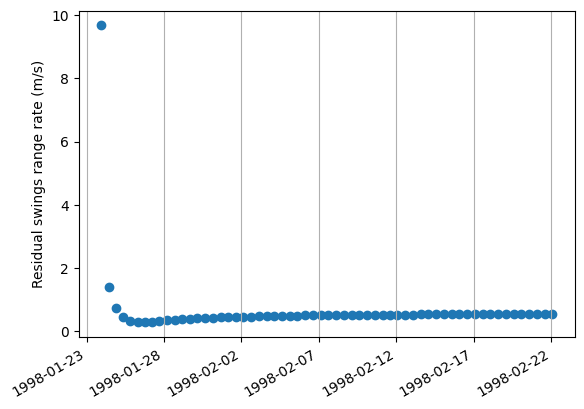

In [11]:
_, ltres_rates = fitr(near_goldstone_orbit, [dss34], epochs, rdata_ltlags, "Fit light-time lags")

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 55
    # data points      = 720
    # variables        = 6
    chi-square         = 1.0063e+11
    reduced chi-square = 1.4094e+08
    Akaike info crit   = 13515.9434
    Bayesian info crit = 13543.4189
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.83960894 (init = -1.839425)
    raan:  1.54877084 (init = 1.540059)
    argp:  2.53588827 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:02:48.837265

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 6908917.068596319 m , altitude: 530780.4685963197 m
[2749.422015622258, 1398.90059828758

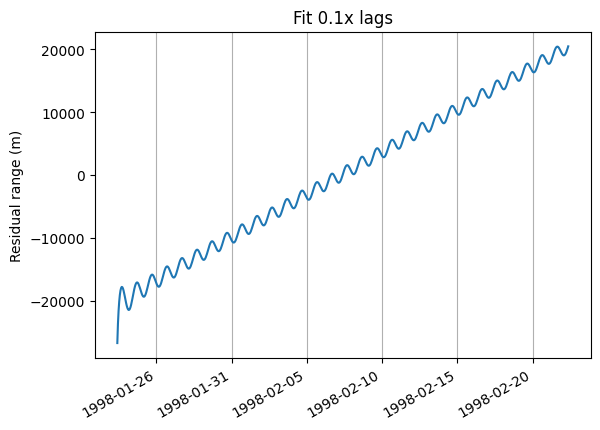

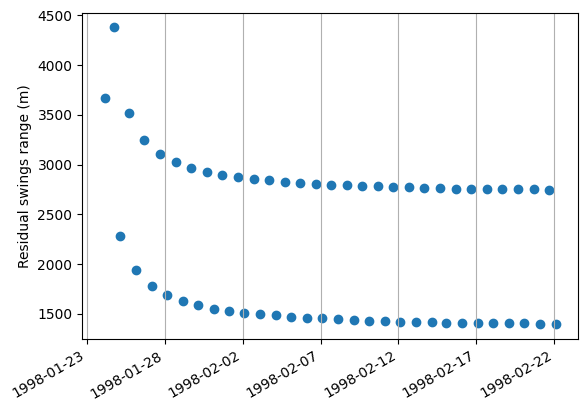

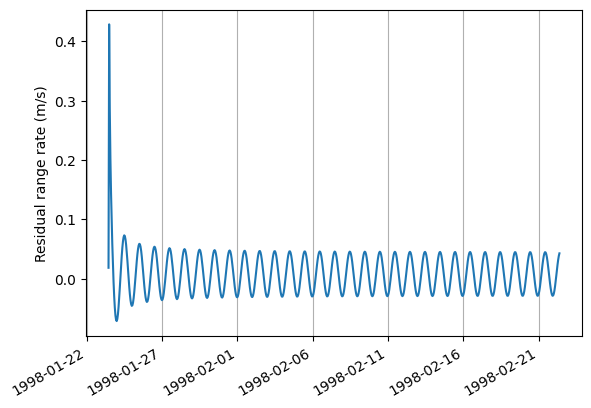

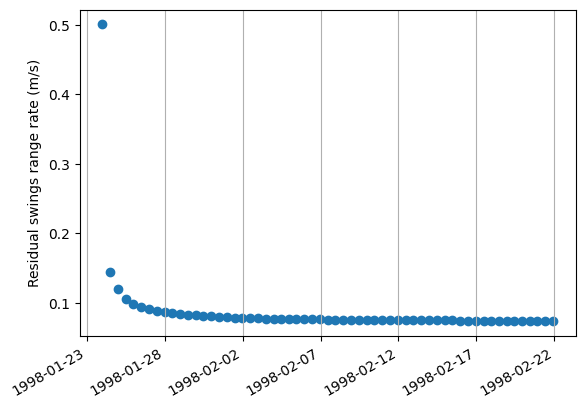

In [12]:
_,_ = fitr(near_goldstone_orbit, [dss34], epochs, rdata_scaledlags, f'Fit {scalefactor}x lags')

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 100
    # data points      = unknown
    # variables        = 6
    chi-square         = unknown
    reduced chi-square = unknown
    Akaike info crit   = unknown
    Bayesian info crit = unknown
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.84127148 (init = -1.839425)
    raan:  1.56647354 (init = 1.540059)
    argp:  2.54027059 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:04:34.985820

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 6908917.068596319 m , altitude: 530780.4685963197 m
[13771.974954754114, 73.54891300201416, 138

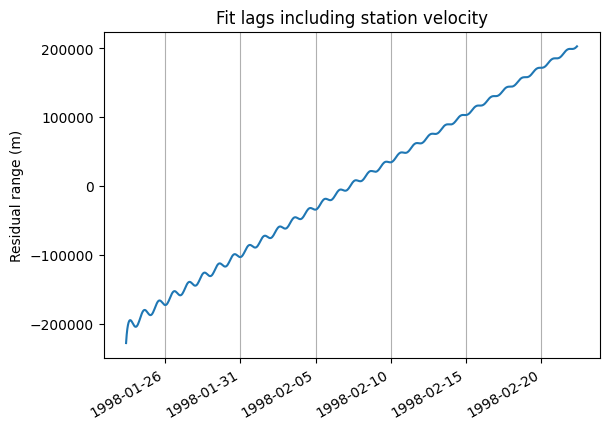

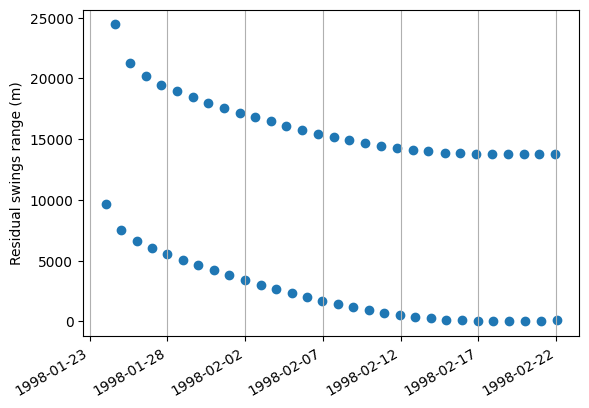

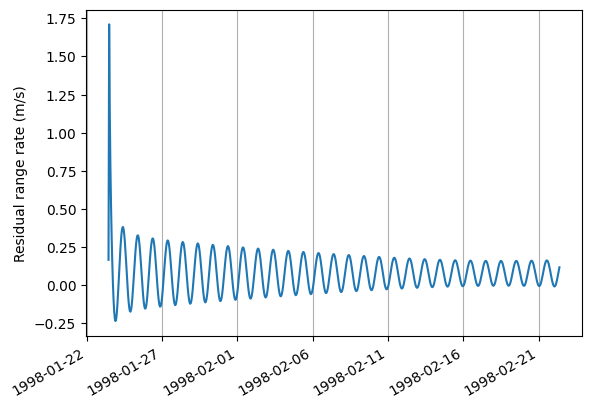

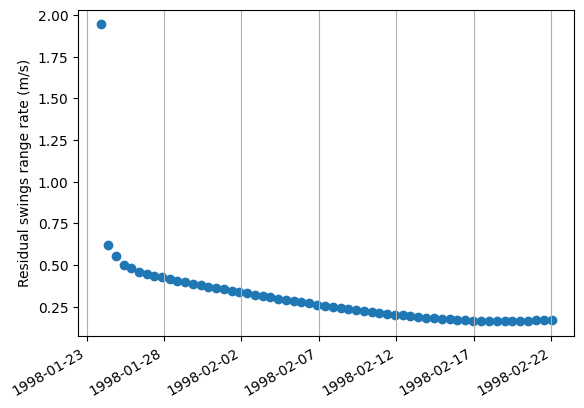

In [13]:
_, fullres_rates = fitr(near_goldstone_orbit, [dss34], epochs, rdata_ltlags_full, "Fit lags including station velocity")

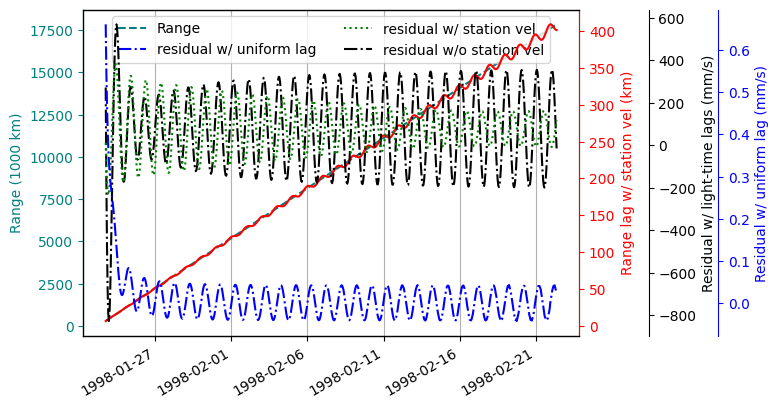

In [14]:
with visualization.time_support():
    fig, ax = plt.subplots()
    plt.xlabel('')
    plt.grid(axis='x')
    skip = 7
    skip1 = skip+1

    if tracking_period > 5*u.day:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    else:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

    ax.set_ylabel('Range (1000 km)', color = "teal")
    ax.spines['left'].set(color="teal")
    ax.tick_params(axis="y", colors="teal")

    ax2 = ax.twinx()
    ax2.set_ylabel('Range lag w/ station vel (km)', color = "red")
    ax2.spines['right'].set(color="red")
    ax2.tick_params(axis="y", colors="red")

    ax3 = ax.twinx()
    ax3.set_ylabel('Residual w/ light-time lags (mm/s)', color = "black")
    ax3.spines['right'].set_position(('outward', 50))
    
    ax4 = ax.twinx()
    ax4.set_ylabel('Residual w/ uniform lag (mm/s)', color = "blue")
    ax4.spines['right'].set(position=('outward', 100), color = "blue")
    ax4.tick_params(axis="y", colors="blue")

    
    #h1 = ax.axhline(y = 929, linestyle = "dotted", color='black', label="Earth SOI")
    #h2 = ax4.axhline(y = 384.4, linestyle = "dotted", color='black', label="Distance to moon")
    
    p1, = ax.plot(epochs[skip1:], [1e-3*v[0].to_value(u.km) for v in rdata_ref[skip1:]],
                  linestyle="dashed", color="teal", label="Range")
    p2, = ax2.plot(epochs[skip1:], [v.to_value(u.km) for v in rlags_full[skip1:]],
                   linestyle="-", color="red", label="lag Δv")
    
    p3, = ax3.plot(epochs[skip1:], [1e3*v for v in ltres_rates[skip:]],
                   linestyle='-.', color="black", label="residual w/o station vel")
    p4, = ax3.plot(epochs[skip1:], [1e3*v for v in fullres_rates[skip:]],
                   linestyle="dotted", color="green", label="residual w/ station vel")
    p5, = ax4.plot(epochs[skip1:], [1e3*v for v in const_rates[skip:]],
                   linestyle="-.", color="blue", label="residual w/ uniform lag")
    
    ax.legend(handles=[p1, p5, p4, p3], loc="upper center", ncol=2)
    plt.gcf().autofmt_xdate()
    plt.savefig(f'near_sim_postencounter_range-{int(tracking_period.to_value(u.day))}d.pdf', bbox_inches='tight')